# Extract Data from yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

df = yf.download('TSLA', 
                  start='2019-01-01', 
                  end='2024-4-29', 
                  progress=False)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600
2024-04-23,143.330002,147.259995,141.110001,144.679993,144.679993,124545100
2024-04-24,162.839996,167.970001,157.509995,162.130005,162.130005,181178000
2024-04-25,158.960007,170.880005,158.360001,170.179993,170.179993,126427500
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,109815700


In [2]:
df['Date'] = df.index  # Create a new column 'Date' with the index values
df.reset_index(drop=True, inplace=True) 

In [3]:
close_df = df[['Date', 'Close']]

# Create a Window Function

In [4]:
def window(df, column_name, k):
    df_copy = df.copy()  
    for i in range(1, k + 1):
        new_column_name = f"{column_name}-{i}"
        df_copy[new_column_name] = df_copy[column_name].shift(i)
    # Swap column names
    column_names = list(df_copy.columns)
    return df_copy.iloc[:, ::-1].drop(range(k))

window_size = 7
close_df = window(close_df, 'Close', window_size)
#close_df = close_df.drop(columns = ['Date'])
close_df.tail(10)

,Close-7,Close-6,Close-5,Close-4,Close-3,Close-2,Close-1,Close,Date
1329,171.110001,164.899994,172.979996,176.880005,171.759995,174.600006,171.050003,161.479996,2024-04-15
1330,164.899994,172.979996,176.880005,171.759995,174.600006,171.050003,161.479996,157.110001,2024-04-16
1331,172.979996,176.880005,171.759995,174.600006,171.050003,161.479996,157.110001,155.449997,2024-04-17
1332,176.880005,171.759995,174.600006,171.050003,161.479996,157.110001,155.449997,149.929993,2024-04-18
1333,171.759995,174.600006,171.050003,161.479996,157.110001,155.449997,149.929993,147.050003,2024-04-19
1334,174.600006,171.050003,161.479996,157.110001,155.449997,149.929993,147.050003,142.050003,2024-04-22
1335,171.050003,161.479996,157.110001,155.449997,149.929993,147.050003,142.050003,144.679993,2024-04-23
1336,161.479996,157.110001,155.449997,149.929993,147.050003,142.050003,144.679993,162.130005,2024-04-24
1337,157.110001,155.449997,149.929993,147.050003,142.050003,144.679993,162.130005,170.179993,2024-04-25
1338,155.449997,149.929993,147.050003,142.050003,144.679993,162.130005,170.179993,168.289993,2024-04-26


In [5]:
close_df_copy = close_df.copy()
close_df_copy = close_df_copy.drop('Date', axis = 1)

# Skewness

In [6]:
for col in close_df_copy.columns:
    print(col, close_df_copy[col].skew())

Close-7 -0.18775008632462042
Close-6 -0.18872407203207256
Close-5 -0.1896218128368702
Close-4 -0.19043032473333413
Close-3 -0.1913091672058382
Close-2 -0.19255914945283617
Close-1 -0.1939836813226779
Close -0.19537154400641385


In [7]:
X = close_df_copy.drop(columns = 'Close')
y = close_df_copy['Close'] 

In [8]:
print(X.shape, y.shape)

(1332, 7) (1332,)


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1, 1))

In [10]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [11]:
print(X_train.shape, X_test.shape)

(1065, 7) (267, 7)


# Machine Learning

# Parametric Approch

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

lr = LinearRegression()
ridge = Ridge()
EN = ElasticNet()

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(actual, forecast):
    
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast lists must be the same")
    
    absolute_errors = [abs(actual[i] - forecast[i]) for i in range(len(actual))]
    percentage_errors = [absolute_errors[i] / actual[i] * 100 for i in range(len(actual))]
    mape = sum(percentage_errors) / len(actual)
    return mape
    
def rearrange(y):
    y_lst = []
    for i in y:
        for j in i:
         y_lst.append(j)
    return y_lst
    
def non_parametric(model):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_pred_full_scaled = scaler_y.inverse_transform(train_pred.reshape(-1, 1))
    train_full_scaled = scaler_y.inverse_transform(y_train)
    
    y_TRAIN = train_full_scaled
    y_PRED_TRAIN = train_pred_full_scaled
    
    pred_full_scaled = scaler_y.inverse_transform(test_pred.reshape(-1, 1))
    test_full_scaled = scaler_y.inverse_transform(y_test)
    
    y_TEST = test_full_scaled
    y_PRED = pred_full_scaled
    
    y_TEST = y_TEST[-256:]
    y_PRED = y_PRED[-256:]
    
    mae = mean_absolute_error(y_TEST, y_PRED)
    RMSE = rmse(y_TEST, y_PRED)
    MAPE =  calculate_mape(y_TEST, y_PRED)
    r2 = r2_score(y_TEST, y_PRED)
    return mae, RMSE, MAPE, r2, model, rearrange(y_TRAIN), rearrange(y_PRED_TRAIN), rearrange(y_TEST), rearrange(y_PRED)


def visual(model, y_TRAIN, y_PRED_TRAIN, y_TEST, y_PRED):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        #pred = model.predict(X_train).flatten()
        train_results = pd.DataFrame(data={'Train Predictions':y_PRED_TRAIN, 'Actuals':y_TRAIN, 'Date': close_df['Date'].iloc[:train_size]})
        train_results.set_index('Date', inplace=True)

        plt.plot(train_results['Train Predictions'], label = 'Train Predictions')
        plt.plot(train_results['Actuals'], label = 'Train')
        plt.title('Training vs Predicitions')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        #pred = model.predict(X_test).flatten()
        test_results = pd.DataFrame(data={'Test Predictions':y_PRED, 'Actuals':y_TEST, 'Date': close_df['Date'].iloc[-256:]})
        test_results.set_index('Date', inplace = True)
        plt.plot(test_results['Test Predictions'], label = 'Test Predictions')
        plt.plot(test_results['Actuals'], label = 'Test')
        plt.title('Testing vs Predicitions')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Linear Regression

In [14]:
mae_lr, rmse_lr, mape_lr, r2_lr, model_lr, y_train_lr, y_train_pred_lg, y_test_lr, y_test_pred_lg = non_parametric(lr)
print("MAE:", mae_lr)
print("RMSE", rmse_lr)
print("MAPE", mape_lr)
print("R2", r2_lr)

MAE: 4.984311093903127
RMSE 6.742716372280001
MAPE [2.28956303]
R2 0.9678877792226598


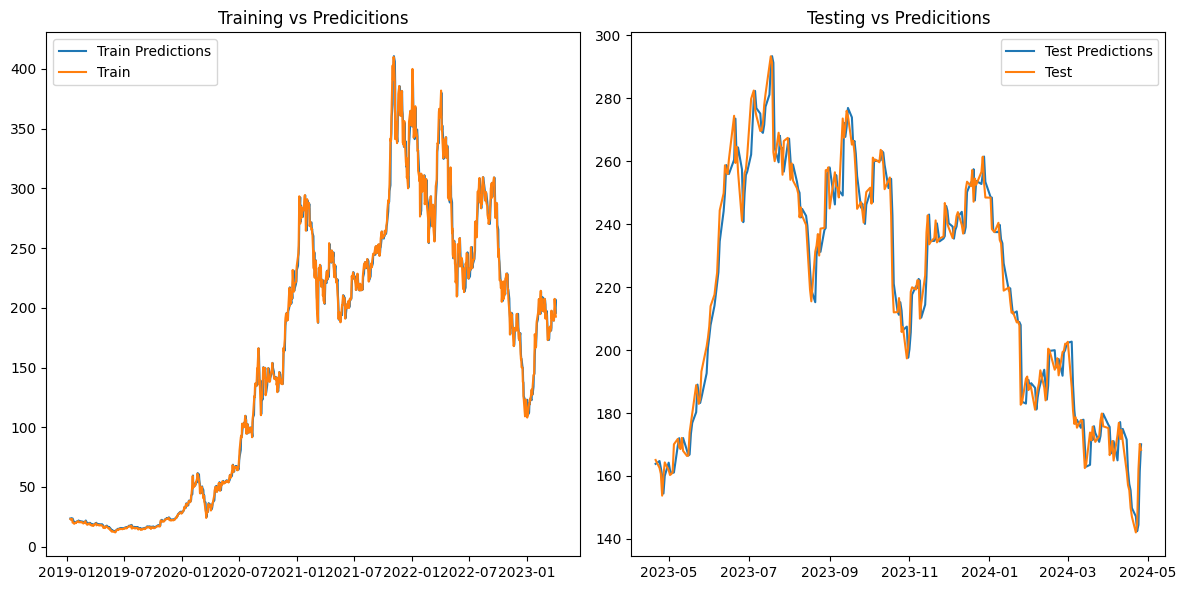

In [15]:
visual(model_lr,  y_train_lr, y_train_pred_lg, y_test_lr, y_test_pred_lg)

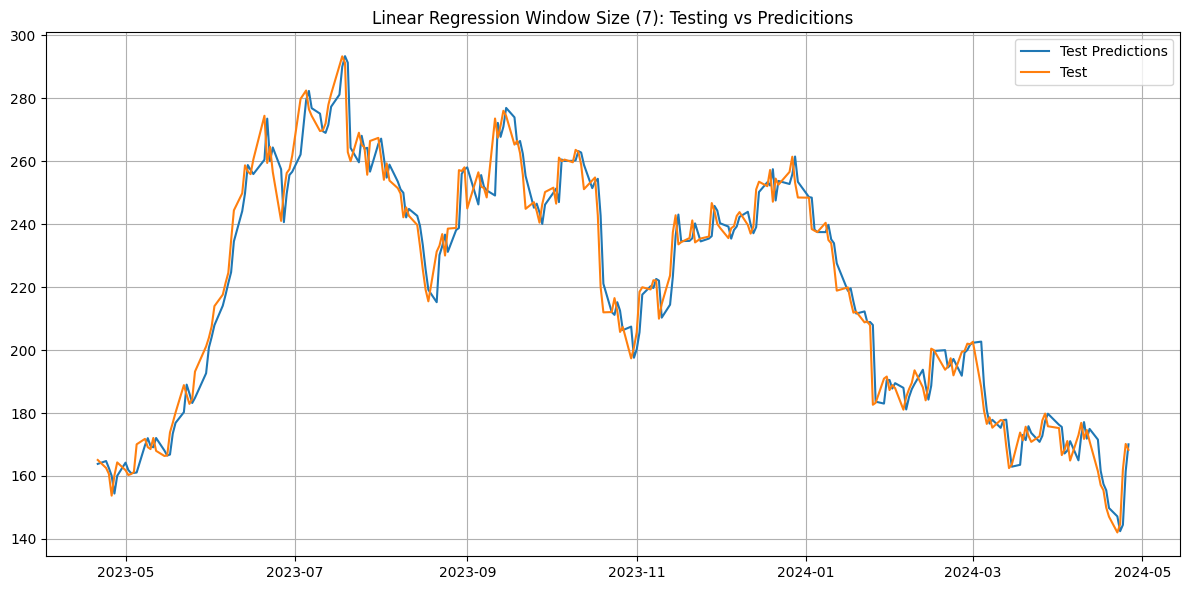

In [16]:
test_results = pd.DataFrame(data={'Test Predictions':y_test_pred_lg, 'Actuals':y_test_lr, 'Date': close_df['Date'].iloc[-256:]})
test_results.set_index('Date', inplace = True)

plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Test Predictions'], label = 'Test Predictions')
plt.plot(test_results['Actuals'], label = 'Test')

plt.title('Linear Regression Window Size (7): Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Ridge Regression

In [17]:
mae_ridge, rmse_ridge, mape_ridge, r2_ridge, model_ridge, y_train_ridge, y_train_pred_ridge, y_test_ridge, y_test_pred_ridge = non_parametric(ridge)

print("MAE:", mae_ridge)
print("RMSE", rmse_ridge)
print("MAPE", mape_ridge)
print("R2", r2_ridge)

MAE: 6.345718225780551
RMSE 8.258860471475487
MAPE [2.92814655]
R2 0.9518228821110036


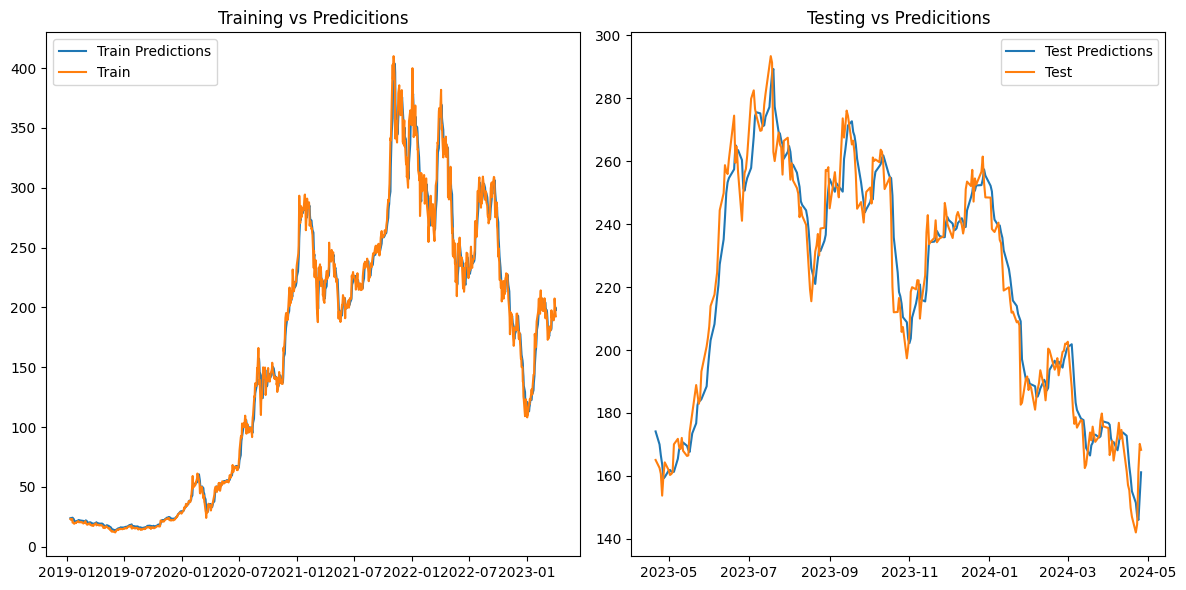

In [18]:
visual(model_ridge, y_train_ridge, y_train_pred_ridge, y_test_ridge, y_test_pred_ridge)

# Non-Parametric Approch

In [19]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

gb = GradientBoostingRegressor()
rf = RandomForestRegressor()
et = ExtraTreesRegressor()
xgb = XGBRegressor()
lgm = LGBMRegressor(verbose=-1)
cat = CatBoostRegressor(silent=True)

ModuleNotFoundError: No module named 'xgboost'

In [22]:
!pip install catboost

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 1.9 MB/s eta 0:00:53
   ---------------------------------------- 0.5/101.1 MB 8.5 MB/s eta 0:00:12
   ---------------------------------------- 1.1/101.1 MB 10.1 MB/s eta 0:00:10
    --------------------------------------- 1.6/101.1 MB 10.5 MB/s eta 0:00:10
    --------------------------------------- 2.2/101.1 MB 10.8 MB/s eta 0:00:10
   - -------------------------------------- 2.7/101.1 MB 10.9 MB/s eta 0:00:09
   - -------------------------------------- 3.3/101.1 MB 11.1 MB/s eta 0:00:09
   - -------------------------------------- 3.9/101.1 MB 11.3 MB/s eta 0:00:09
   - -------------------------------------- 4.5/101.1 MB 11.4 MB/s eta 0:00:09
   - -------------------------------------- 5.0/101.1 MB 11.4 MB/s eta 0:00:09
   -- ------------------------------------- 5.6/101.1 MB 11.5 MB/s eta 0:00:

# Gradient Boosting

In [ ]:
mae_gb, rmse_gb, mape_gb, r2_gb, model_gb, y_train_gb, y_train_pred_gb, y_test_gb, y_test_pred_gb = non_parametric(gb)
print("MAE:", mae_gb)
print("RMSE", rmse_gb)
print("MAPE", mape_gb)
print("R2", r2_gb)

In [ ]:
visual(model_gb, y_train_gb, y_train_pred_gb, y_test_gb, y_test_pred_gb)

# Random Forest

In [ ]:
mae_rf, rmse_rf, mape_rf, r2_rf, model_rf, y_train_rf, y_train_pred_rf, y_test_rf, y_test_pred_rf = non_parametric(rf)
print("MAE:", mae_rf)
print("RMSE", rmse_rf)
print("MAPE", mape_rf)
print("R2", r2_rf)

In [ ]:
visual(model_rf, y_train_rf, y_train_pred_rf, y_test_rf, y_test_pred_rf)

# Extra Trees

In [ ]:
mae_et, rmse_et, mape_et, r2_et, model_et, y_train_et, y_train_pred_et, y_test_et, y_test_pred_et = non_parametric(et)
print("MAE:", mae_et)
print("RMSE", rmse_et)
print("MAPE", mape_et)
print("R2", r2_et)

In [ ]:
visual(model_et, y_train_et, y_train_pred_et, y_test_et, y_test_pred_et)

# XGB

In [ ]:
mae_xgb, rmse_xgb, mape_xgb, r2_xgb, model_xgb, y_train_xgb, y_train_pred_xgb, y_test_xgb, y_test_pred_xgb = non_parametric(xgb)
print("MAE:", mae_xgb)
print("RMSE", rmse_xgb)
print("MAPE", mape_xgb)
print("R2", r2_xgb)

In [ ]:
visual(model_xgb, y_train_xgb, y_train_pred_xgb, y_test_xgb, y_test_pred_xgb)

In [ ]:
mae_lgm, rmse_lgm, mape_lgm, r2_lgm, model_lgm, y_train_lgm, y_train_pred_lgm, y_test_lgm, y_test_pred_lgm = non_parametric(lgm)
print("MAE:", mae_lgm)
print("RMSE", rmse_lgm)
print("MAPE", mape_lgm)
print("R2", r2_lgm)

In [ ]:
visual(model_lgm, y_train_lgm, y_train_pred_lgm, y_test_lgm, y_test_pred_lgm)

# CAT Boost

In [ ]:
mae_cat, rmse_cat, mape_cat,r2_cat, model_cat, y_train_cat, y_train_pred_cat, y_test_cat, y_test_pred_cat = non_parametric(cat)
print("MAE:", mae_cat)
print("RMSE", rmse_cat)
print("MAPE", mape_cat)
print("R2", r2_cat)

In [ ]:
visual(model_cat, y_train_cat, y_train_pred_cat, y_test_cat, y_test_pred_cat)

In [ ]:
model_df_non = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression','Gradient Boosting', 'Random Forest', 'Extra Tree', 'XGB', 'LGM', 'CAT'],
    'MAE': [mae_lr, mae_ridge, mae_gb, mae_rf, mae_et, mae_xgb, mae_lgm, mae_cat],
    'RMSE': [rmse_lr, rmse_ridge, rmse_gb, rmse_rf, rmse_et, rmse_xgb, rmse_lgm, rmse_cat],
    'MAPE': [mape_lr, mape_ridge,mape_gb, mape_rf, mape_et, mape_xgb, mape_lgm, mape_cat],
    'R2':[r2_lr, r2_ridge, r2_gb, r2_rf, r2_et, r2_xgb, r2_lgm, r2_cat]
})

model_df_non.sort_values(by = 'MAPE', ascending = True)